# Fetch data from Kaggle

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("masoudnickparvar/brain-tumor-mri-dataset", path='./data/raw')

print("Path to dataset files:", path)

# Visualize data

In [ ]:
import os 
import numpy as np
import cv2
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt 
from matplotlib.image import imread
from PIL import Image

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout 
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from tensorflow.keras.callbacks import EarlyStopping

In [100]:
# Define the directories
train_dir = "raw\\train"
test_dir = "raw\\test"

classes = os.listdir(train_dir)
classes


['glioma', 'meningioma', 'notumor', 'pituitary']

In [101]:
image_paths = []
image_labels = []

categories = os.listdir(train_dir)

for category in categories:
    category_path = os.path.join(train_dir, category)
    images = os.listdir(category_path)
    
    for image in images:
        image_path = os.path.join(category_path, image)
        image_paths.append(image_path)
        image_labels.append(category)

train_df = pd.DataFrame(data={'filepaths': image_paths, 'labels': image_labels})
train_df

,filepaths,labels
0,raw\train\glioma\Tr-glTr_0000.jpg,glioma
1,raw\train\glioma\Tr-glTr_0001.jpg,glioma
2,raw\train\glioma\Tr-glTr_0002.jpg,glioma
3,raw\train\glioma\Tr-glTr_0003.jpg,glioma
4,raw\train\glioma\Tr-glTr_0004.jpg,glioma
...,...,...
5707,raw\train\pituitary\Tr-pi_1452.jpg,pituitary
5708,raw\train\pituitary\Tr-pi_1453.jpg,pituitary
5709,raw\train\pituitary\Tr-pi_1454.jpg,pituitary
5710,raw\train\pituitary\Tr-pi_1455.jpg,pituitary


In [102]:
image_paths = []
image_labels = []

categories = os.listdir(test_dir)

for category in categories:
    category_path = os.path.join(test_dir, category)
    images = os.listdir(category_path)
    
    for image in images:
        image_path = os.path.join(category_path, image)
        image_paths.append(image_path)
        image_labels.append(category)

test_df = pd.DataFrame(data={'filepaths': image_paths, 'labels': image_labels})
test_df

,filepaths,labels
0,raw\test\glioma\Te-glTr_0000.jpg,glioma
1,raw\test\glioma\Te-glTr_0001.jpg,glioma
2,raw\test\glioma\Te-glTr_0002.jpg,glioma
3,raw\test\glioma\Te-glTr_0003.jpg,glioma
4,raw\test\glioma\Te-glTr_0004.jpg,glioma
...,...,...
1306,raw\test\pituitary\Te-pi_0295.jpg,pituitary
1307,raw\test\pituitary\Te-pi_0296.jpg,pituitary
1308,raw\test\pituitary\Te-pi_0297.jpg,pituitary
1309,raw\test\pituitary\Te-pi_0298.jpg,pituitary


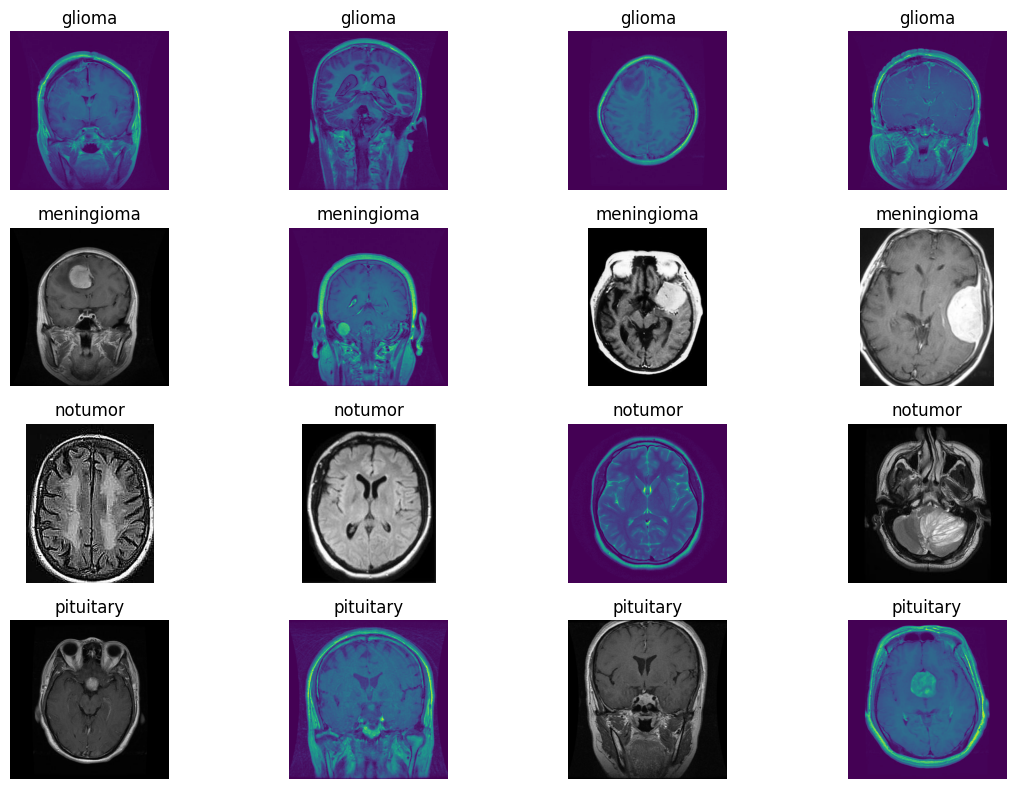

In [103]:
def plot_class_samples(df, classes, num_samples=4):
    plt.figure(figsize=(12,8))
    
    for i, cls in enumerate(classes):
        class_images = df[df['labels'] == cls]['filepaths'].sample(num_samples, random_state=42)
        
        for j, img_path in enumerate(class_images):
            img = Image.open(img_path)  # Load the image
            plt.subplot(len(classes), num_samples, i * num_samples + j + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(cls)
    
    plt.tight_layout()
    plt.show()
classes = train_df['labels'].unique()

plot_class_samples(train_df, classes)

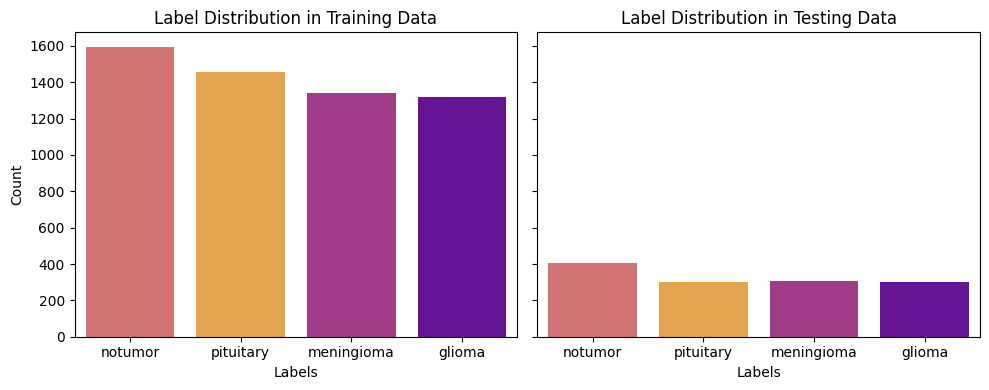

In [104]:
# Set up the figure with two subplots side by side
fig, axes = plt.subplots(1, 2, figsize=(10, 4), sharey=True)

# Plot for train_df
sns.countplot(
    data=train_df,
    x='labels',
    hue='labels',
    palette='plasma',
    order=train_df['labels'].value_counts().index,
    legend=False,
    ax=axes[0]
)
axes[0].set_title("Label Distribution in Training Data")
axes[0].set_xlabel("Labels")
axes[0].set_ylabel("Count")
axes[0].tick_params(axis='x')

# Plot for test_df
sns.countplot(
    data=test_df,
    x='labels',
    hue='labels',
    palette='plasma',
    order=train_df['labels'].value_counts().index,  # Keep same order as train
    legend=False,
    ax=axes[1]
)
axes[1].set_title("Label Distribution in Testing Data")
axes[1].set_xlabel("Labels")
axes[1].tick_params(axis='x')

# Adjust layout for clarity
plt.tight_layout()
plt.show()

# Data preprocessing

In [105]:
def preprocess_brain_image(image_path, target_size=(512, 512)):
    # Read image
    image = cv2.imread(image_path, cv2.IMREAD_COLOR)
    image = cv2.resize(image, target_size)

    # Convert to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Apply CLAHE for contrast enhancement
    clahe = cv2.createCLAHE(clipLimit=0.5, tileGridSize=(4, 4))
    enhanced = clahe.apply(gray)

    # Normalize to [0, 1]
    normalized = (enhanced / 255.0 * 255).astype(np.uint8)

    return image, normalized

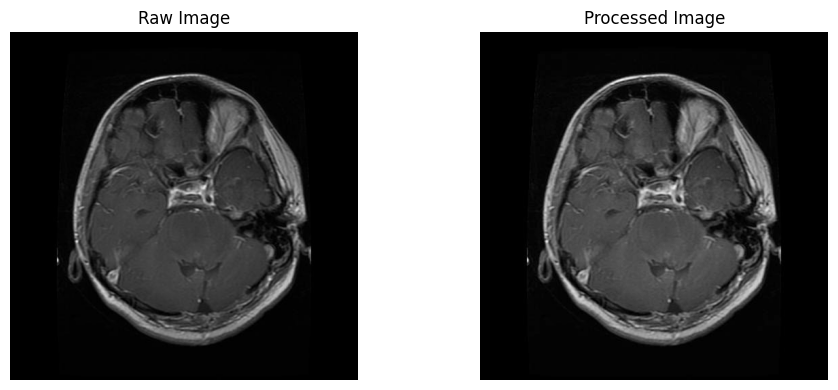

In [106]:
# Example usage
image_path = "raw/test/glioma/Te-gl_0010.jpg"  # Replace with your image path
raw_image, processed_image = preprocess_brain_image(image_path)

# Display raw and processed images side by side
plt.figure(figsize=(10, 4))

# Raw image
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(raw_image, cv2.COLOR_BGR2RGB))
plt.title("Raw Image")
plt.axis("off")

# Processed image
plt.subplot(1, 2, 2)
plt.imshow(processed_image, cmap="gray")
plt.title("Processed Image")
plt.axis("off")

plt.tight_layout()
plt.show()

# Save preprocessed images

In [109]:
# Function to process images and create the new DataFrame
def process_images_and_create_df(df, raw_base_dir="raw", processed_base_dir="processed"):
    processed_image_paths = []

    for idx, row in df.iterrows():
        raw_path = row['filepaths']
        processed_path = raw_path.replace(raw_base_dir, processed_base_dir)

        # Process the image first
        _, processed_image = preprocess_brain_image(raw_path)
        if processed_image is not None:
            # Create only the parent directory, not the full file path
            processed_dir = os.path.dirname(processed_path)
            os.makedirs(processed_dir, exist_ok=True)

            # Save the processed image
            cv2.imwrite(processed_path, processed_image)
            processed_image_paths.append(processed_path)
        else:
            print(f"Failed to process {raw_path}")
            processed_image_paths.append(None)

    # Create the new DataFrame with processed paths
    new_df = df.copy()
    new_df['processed_filepaths'] = processed_image_paths
    return new_df

In [ ]:
# Example usage
test_processed_df = process_images_and_create_df(test_df)
train_processed_df = process_images_and_create_df(train_df)

In [113]:
# Combine the DataFrames
combined_df = pd.concat([train_processed_df, test_processed_df], ignore_index=True)

# Save to CSV file
output_csv_path = "data.csv"
combined_df.to_csv(output_csv_path, index=False)

print(f"Combined DataFrame saved to: {output_csv_path}")

Combined DataFrame saved to: data.csv
